In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import helper, residualbind
sys.path.append('..')
from deepomics import neuralnetwork as nn
from deepomics import fit

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path = '../data/synthetic_hairpin_data/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}

In [8]:
save_path = helper.make_directory('../results', 'hairpin2')

making directory: ../results/hairpin2


In [4]:
# get shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model
model_layers, optimization = residualbind.model(input_shape, output_shape)
model_layers[-1]['activation'] = 'sigmoid'
optimization['objective'] = 'binary'

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainer
file_path = os.path.join(save_path, 'hairpin')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

In [5]:
# start session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, batch_size=2000, num_epochs=200,
                    patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 200 
[==============================] 100.0% -- elapsed time=3.01s -- loss=0.12324 -- acc=95.477608%  
 
  valid loss:		0.07300
  valid accuracy:	0.97215+/-0.00000
  valid auc-roc:	0.99767+/-0.00000
  valid auc-pr:		0.99307+/-0.00000
Epoch 2 out of 200 
[==============================] 100.0% -- elapsed time=3.00s -- loss=0.11750 -- acc=95.706771%  
 
  valid loss:		0.06990
  valid accuracy:	0.97390+/-0.00000
  valid auc-roc:	0.99788+/-0.00000
  valid auc-pr:		0.99388+/-0.00000
Epoch 3 out of 200 
[==============================] 100.0% -- elapsed time=2.98s -- loss=0.11445 -- acc=95.854175%  
 
  valid loss:		0.06178
  valid accuracy:	0.97731+/-0.00000
  valid auc-roc:	0.99814+/-0.00000
  valid auc-pr:		0.99490+/-0.00000
  lower cross-validation found
  saving model to:  ../results/hairpin3/hairpin_best.ckpt
Epoch 4 out of 200 
[==============================] 100.0% -- elapsed time=2.98s -- loss=0.11008 -- acc=96.015632%  
 
  valid loss:		0.06067
  valid accuracy:	0.9

Epoch 30 out of 200 
[==============================] 100.0% -- elapsed time=3.04s -- loss=0.05879 -- acc=98.028653%  
 
  valid loss:		0.03009
  valid accuracy:	0.98887+/-0.00000
  valid auc-roc:	0.99968+/-0.00000
  valid auc-pr:		0.99904+/-0.00000
  lower cross-validation found
  saving model to:  ../results/hairpin3/hairpin_best.ckpt
Epoch 31 out of 200 
[==============================] 100.0% -- elapsed time=3.02s -- loss=0.05633 -- acc=98.115622%  
 
  valid loss:		0.02786
  valid accuracy:	0.99006+/-0.00000
  valid auc-roc:	0.99978+/-0.00000
  valid auc-pr:		0.99944+/-0.00000
  lower cross-validation found
  saving model to:  ../results/hairpin3/hairpin_best.ckpt
Epoch 32 out of 200 
[==============================] 100.0% -- elapsed time=3.03s -- loss=0.05623 -- acc=98.130733%  
 
  valid loss:		0.02759
  valid accuracy:	0.99008+/-0.00000
  valid auc-roc:	0.99970+/-0.00000
  valid auc-pr:		0.99912+/-0.00000
  lower cross-validation found
  saving model to:  ../results/hairpin3/h

[==============================] 100.0% -- elapsed time=3.08s -- loss=0.03136 -- acc=99.037504%  
 
  valid loss:		0.01622
  valid accuracy:	0.99485+/-0.00000
  valid auc-roc:	0.99990+/-0.00000
  valid auc-pr:		0.99967+/-0.00000
Epoch 90 out of 200 
[==============================] 100.0% -- elapsed time=3.05s -- loss=0.03023 -- acc=99.055216%  
 
  valid loss:		0.01277
  valid accuracy:	0.99608+/-0.00000
  valid auc-roc:	0.99993+/-0.00000
  valid auc-pr:		0.99978+/-0.00000
Epoch 91 out of 200 
[==============================] 100.0% -- elapsed time=3.03s -- loss=0.03099 -- acc=99.043754%  
 
  valid loss:		0.01261
  valid accuracy:	0.99631+/-0.00000
  valid auc-roc:	0.99994+/-0.00000
  valid auc-pr:		0.99981+/-0.00000
Epoch 92 out of 200 
[==============================] 100.0% -- elapsed time=3.05s -- loss=0.02992 -- acc=99.090109%  
 
  valid loss:		0.01422
  valid accuracy:	0.99542+/-0.00000
  valid auc-roc:	0.99994+/-0.00000
  valid auc-pr:		0.99986+/-0.00000
Epoch 93 out of 200 


Epoch 121 out of 200 
[==============================] 100.0% -- elapsed time=3.05s -- loss=0.02565 -- acc=99.248445%  
 
  valid loss:		0.01189
  valid accuracy:	0.99638+/-0.00000
  valid auc-roc:	0.99992+/-0.00000
  valid auc-pr:		0.99979+/-0.00000
Epoch 122 out of 200 
[==============================] 100.0% -- elapsed time=3.09s -- loss=0.02665 -- acc=99.235944%  
 
  valid loss:		0.01136
  valid accuracy:	0.99677+/-0.00000
  valid auc-roc:	0.99995+/-0.00000
  valid auc-pr:		0.99980+/-0.00000
Epoch 123 out of 200 
[==============================] 100.0% -- elapsed time=3.08s -- loss=0.02495 -- acc=99.270317%  
 
  valid loss:		0.00999
  valid accuracy:	0.99735+/-0.00000
  valid auc-roc:	0.99997+/-0.00000
  valid auc-pr:		0.99992+/-0.00000
Epoch 124 out of 200 
[==============================] 100.0% -- elapsed time=3.05s -- loss=0.02532 -- acc=99.277088%  
 
  valid loss:		0.01155
  valid accuracy:	0.99652+/-0.00000
  valid auc-roc:	0.99995+/-0.00000
  valid auc-pr:		0.99974+/-0.00

In [11]:
nntrainer.set_best_parameters(sess)

loading model from:  ../results/hairpin3/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/hairpin3/hairpin_best.ckpt


In [12]:
nntrainer.test_model(sess, test);

  test  loss:		0.00895
  test  accuracy:	0.99785+/-0.00000
  test  auc-roc:	0.99996+/-0.00000
  test  auc-pr:		0.99992+/-0.00000


# Mutagenesis study

In [13]:

def first_order_mutagenesis(sess, nntrainer, X, layer='output'):
    _, seq_length, _, num_alphabet = X.shape

    # get wild-type score
    wt_score = nntrainer.get_activations(sess, {'inputs': X}, layer=layer)

    # generate mutagenesis sequences
    X_mut = np.reshape(np.dot(np.ones((seq_length*num_alphabet, 1)), X), [seq_length*num_alphabet, seq_length, 1, num_alphabet])
    k = 0
    for i in range(seq_length):
        for j in range(num_alphabet):
            X_mut[k, i, 0, :] = 0
            X_mut[k, i, 0, j] = 1        
            k += 1

    # get first order mutagenesis score
    mut_scores = nntrainer.get_activations(sess, {'inputs': X_mut}, layer=layer)

    # calculate log-odds score
    mutagenesis = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)
    mutagenesis = np.reshape(mutagenesis, [seq_length, num_alphabet])
    
    return mutagenesis


def second_order_mutagenesis(sess, nntrainer, X, layer='output'):
    _, seq_length, _, num_alphabet = X.shape

    # get wild-type score
    wt_score = nntrainer.get_activations(sess, {'inputs': X}, layer=layer)
    
    # generate mutagenesis sequences
    num_mut = seq_length**2*num_alphabet**2
    X_mut = np.reshape(np.dot(np.ones((num_mut, 1)), X), [num_mut, seq_length, 1, num_alphabet])
    k = 0
    for i in range(seq_length):
        for j in range(seq_length):
            for m in range(num_alphabet):
                for n in range(num_alphabet):
                    X_mut[k, i, 0, :] = 0
                    X_mut[k, i, 0, m] = 1        
                    X_mut[k, j, 0, :] = 0
                    X_mut[k, j, 0, n] = 1        
                    k += 1

    # get second order mutagenesis score
    mut_scores = nntrainer.get_activations(sess, {'inputs': X_mut}, layer=layer)

    # calculate log-odds score
    log_odds = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)

    # reshape second order scores
    second_mutagenesis = np.zeros((seq_length, seq_length, num_alphabet, num_alphabet))
    k = 0
    for i in range(seq_length):
        for j in range(seq_length):
            for m in range(num_alphabet):
                for n in range(num_alphabet):
                    second_mutagenesis[i,j,m,n] = log_odds[k,0]
                    k += 1
                
    return second_mutagenesis

In [14]:
pos_index = np.where(test['targets'][:,0] == 1)[0]

N = 1000#len(pos_index)

mutagenesis_1 = np.zeros((N, seq_length, num_alphabet))
mutagenesis_2 = np.zeros((N, seq_length, seq_length, num_alphabet, num_alphabet))
for i, index in enumerate(pos_index[:N]):
    X = np.expand_dims(test['inputs'][index], axis=0)
    mutagenesis_1[i,:,:] = first_order_mutagenesis(sess, nntrainer, X)
    mutagenesis_2[i,:,:,:,:] = second_order_mutagenesis(sess, nntrainer, X)
    
    if np.mod(i+1, 200) == 0:
        print("%d out of %d"%(i+1,N))

200 out of 1000
400 out of 1000
600 out of 1000
800 out of 1000
1000 out of 1000


In [15]:
from six.moves import cPickle

with open(os.path.join(save_path, 'mutagenesis_pos.pickle'), 'wb') as f:
    cPickle.dump(mutagenesis_1, f)
    cPickle.dump(mutagenesis_2, f)

In [9]:
from six.moves import cPickle

with open(os.path.join(save_path, 'mutagenesis_pos.pickle'), 'rb') as f:
    mutagenesis_1 = cPickle.load(f)
    mutagenesis_2 = cPickle.load(f)

IOError: [Errno 2] No such file or directory: '../results/hairpin2/mutagenesis_pos.pickle'

# tmp

In [178]:
# mutagenesis_2 = mutagenesis_2[:1000]

In [17]:
# calculate average 4x4 for each canonical pair position

# 4x4 vs position

mut = np.mean(mutagenesis_2, axis=0)

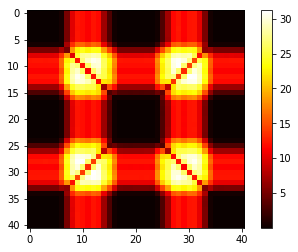

In [18]:
norm = np.sqrt(np.sum(np.sum(mut**2, axis=3), axis=2))
plt.imshow(norm, interpolation='none', cmap='hot')
plt.colorbar()

In [19]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset = np.vstack([range(6,17), range(25,36)[::-1]]).T

pos_mask = np.zeros((4,4))
neg_mask = np.ones((4,4))
for i in range(4):
    pos_mask[i,3-i] = 1
    neg_mask[i,3-i] = 0
    
    
pos_score = np.zeros((41,41))
neg_score = np.zeros((41,41))
for j in range(41):
    for i in range(41):
        pos_score[j,i] = np.mean(mut[j,i,:,:]*pos_mask)
        neg_score[j,i] = np.mean(mut[j,i,:,:]*neg_mask)
        

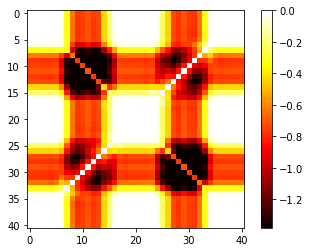

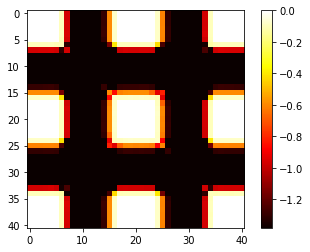

In [29]:
plt.figure()
plt.imshow(pos_score, interpolation='none', cmap='hot', vmax=0.0, vmin=-1.38)
plt.colorbar()
outfile = os.path.join(save_path, 'mutagenesis_pos_mask.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

plt.figure()
plt.imshow(neg_score, interpolation='none', cmap='hot', vmax=0.0, vmin=-1.38)
plt.colorbar()
outfile = os.path.join(save_path, 'mutagenesis_neg_mask.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [1]:
import numpy as np

In [4]:
np.log(0.25)

-1.3862943611198906

In [3]:
np.exp(-1.38)

0.2515785530597565

In [6]:
np.log(1/4.)

-1.3862943611198906

0.2

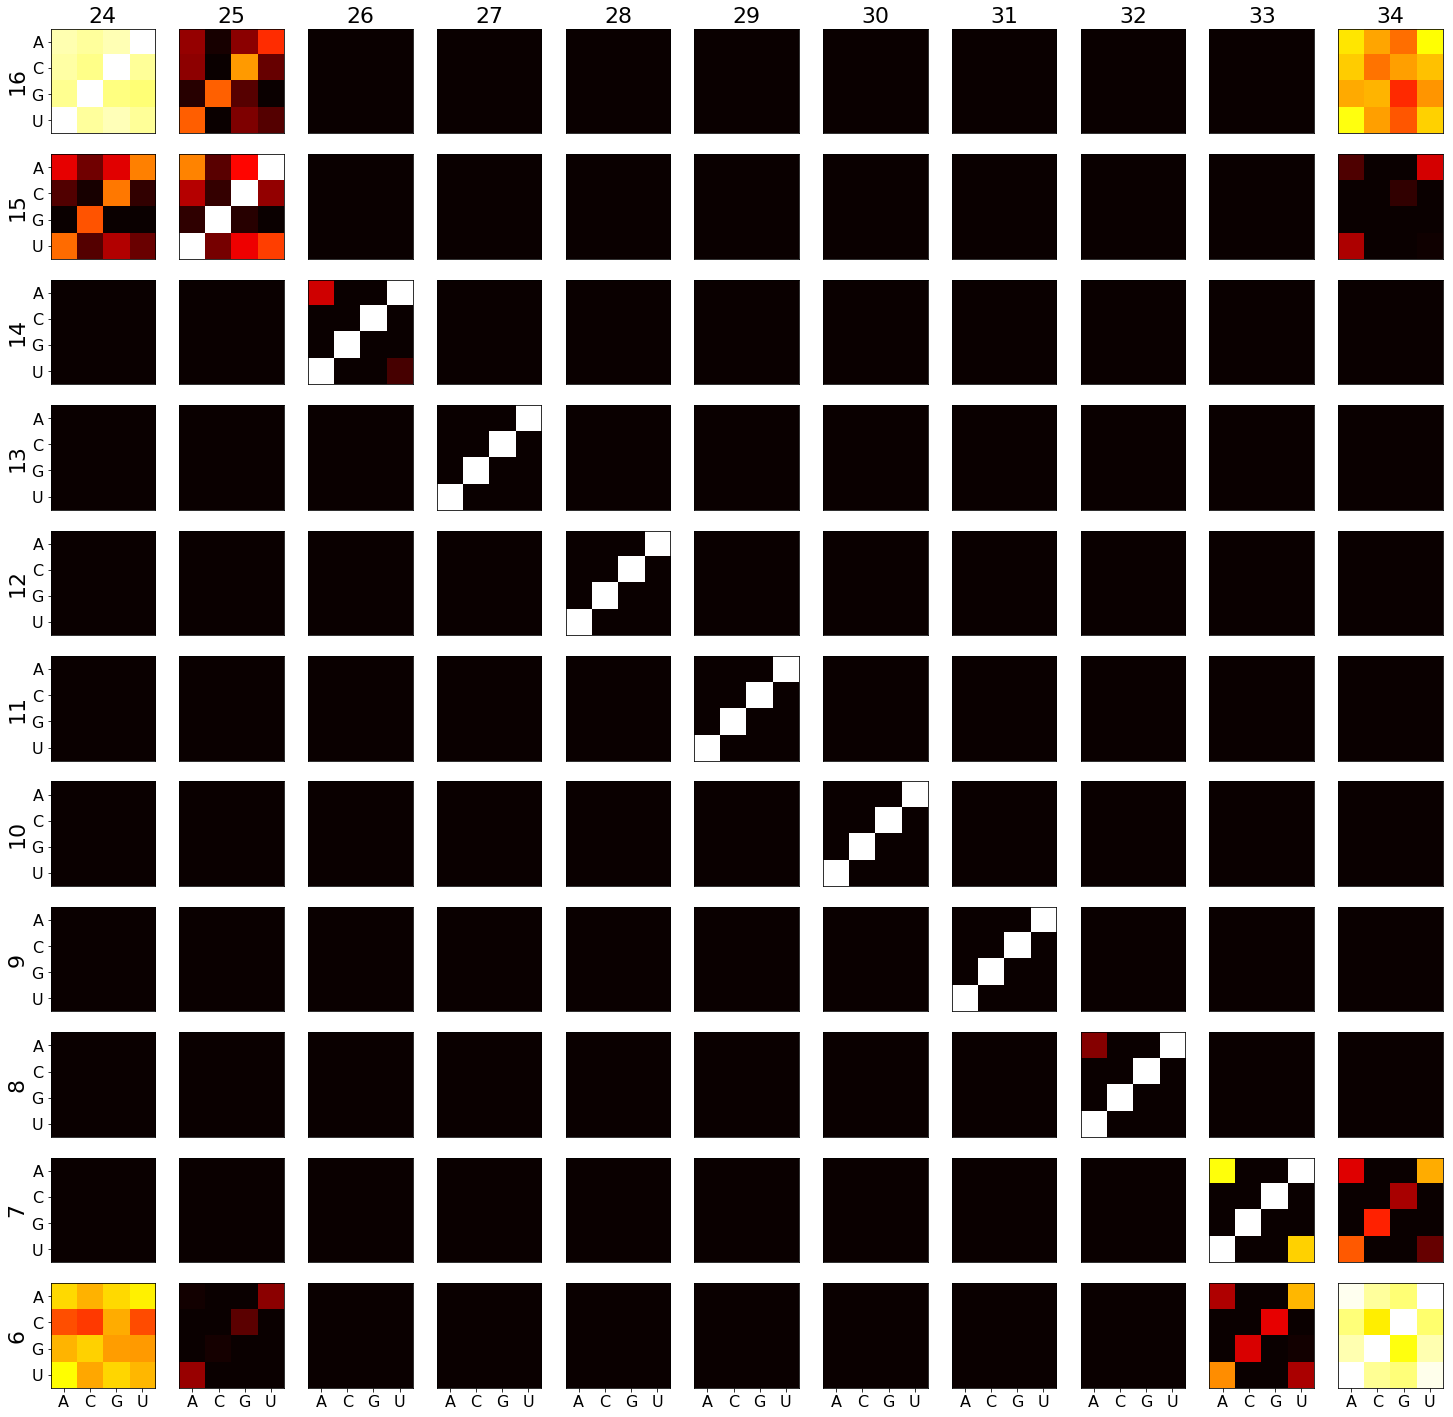

In [28]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T

fig = plt.figure(figsize=(25,25))
k = 1
stem1 = range(6,17)[::-1]
stem2 = range(24,35)
for i in stem1:
    for j in stem2:
        plt.subplot(len(stem1),len(stem2),k)
        plt.imshow(mut[i,j,:,:], interpolation='none', cmap='hot', vmin=-1.38, vmax=0.0)
        
        if k in range(1,len(stem1)**2, len(stem1)):
            plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
            plt.ylabel(str(i), fontsize=22)
        else:
            plt.yticks([])
        if k in range(len(stem1)**2-len(stem1)+1,len(stem1)**2+1):
            plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
        else:
            plt.xticks([])

        if k in range(1,len(stem1)+1):
            plt.title(str(j), fontsize=22)
        k += 1

#outfile = os.path.join(save_path, 'mutagenesis_stem_positions_3.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

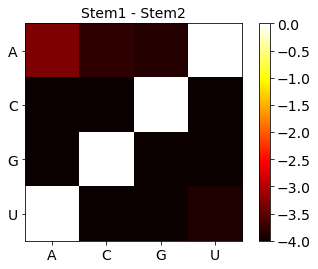

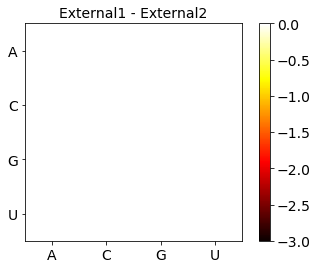

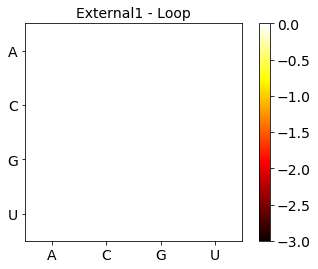

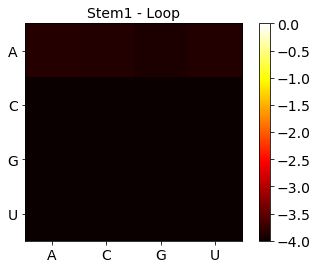

In [210]:
fontsize = 14
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(8,14), range(17,23)[::-1]]).T

fig = plt.figure()
plt.imshow(np.mean(mut[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-4, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Stem2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_stem1-stem2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - External2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1-external2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-4, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize);
outfile = os.path.join(save_path, 'mutagenesis_stem1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

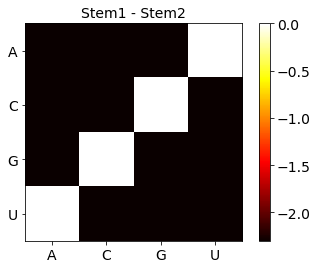

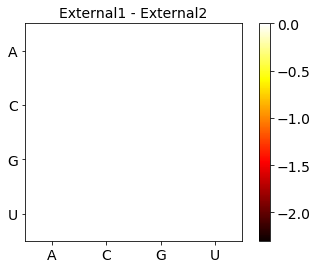

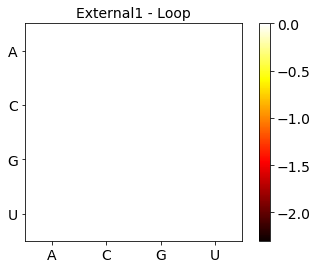

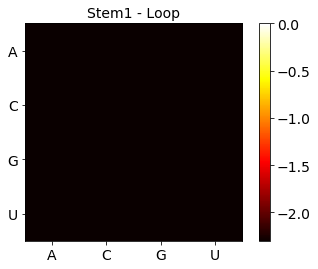

In [200]:
fontsize = 14
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(8,14), range(17,23)[::-1]]).T

fig = plt.figure()
plt.imshow(np.mean(mut[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Stem2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_stem1-stem2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - External2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1-external2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize);
outfile = os.path.join(save_path, 'mutagenesis_stem1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# individual mutagenesis study

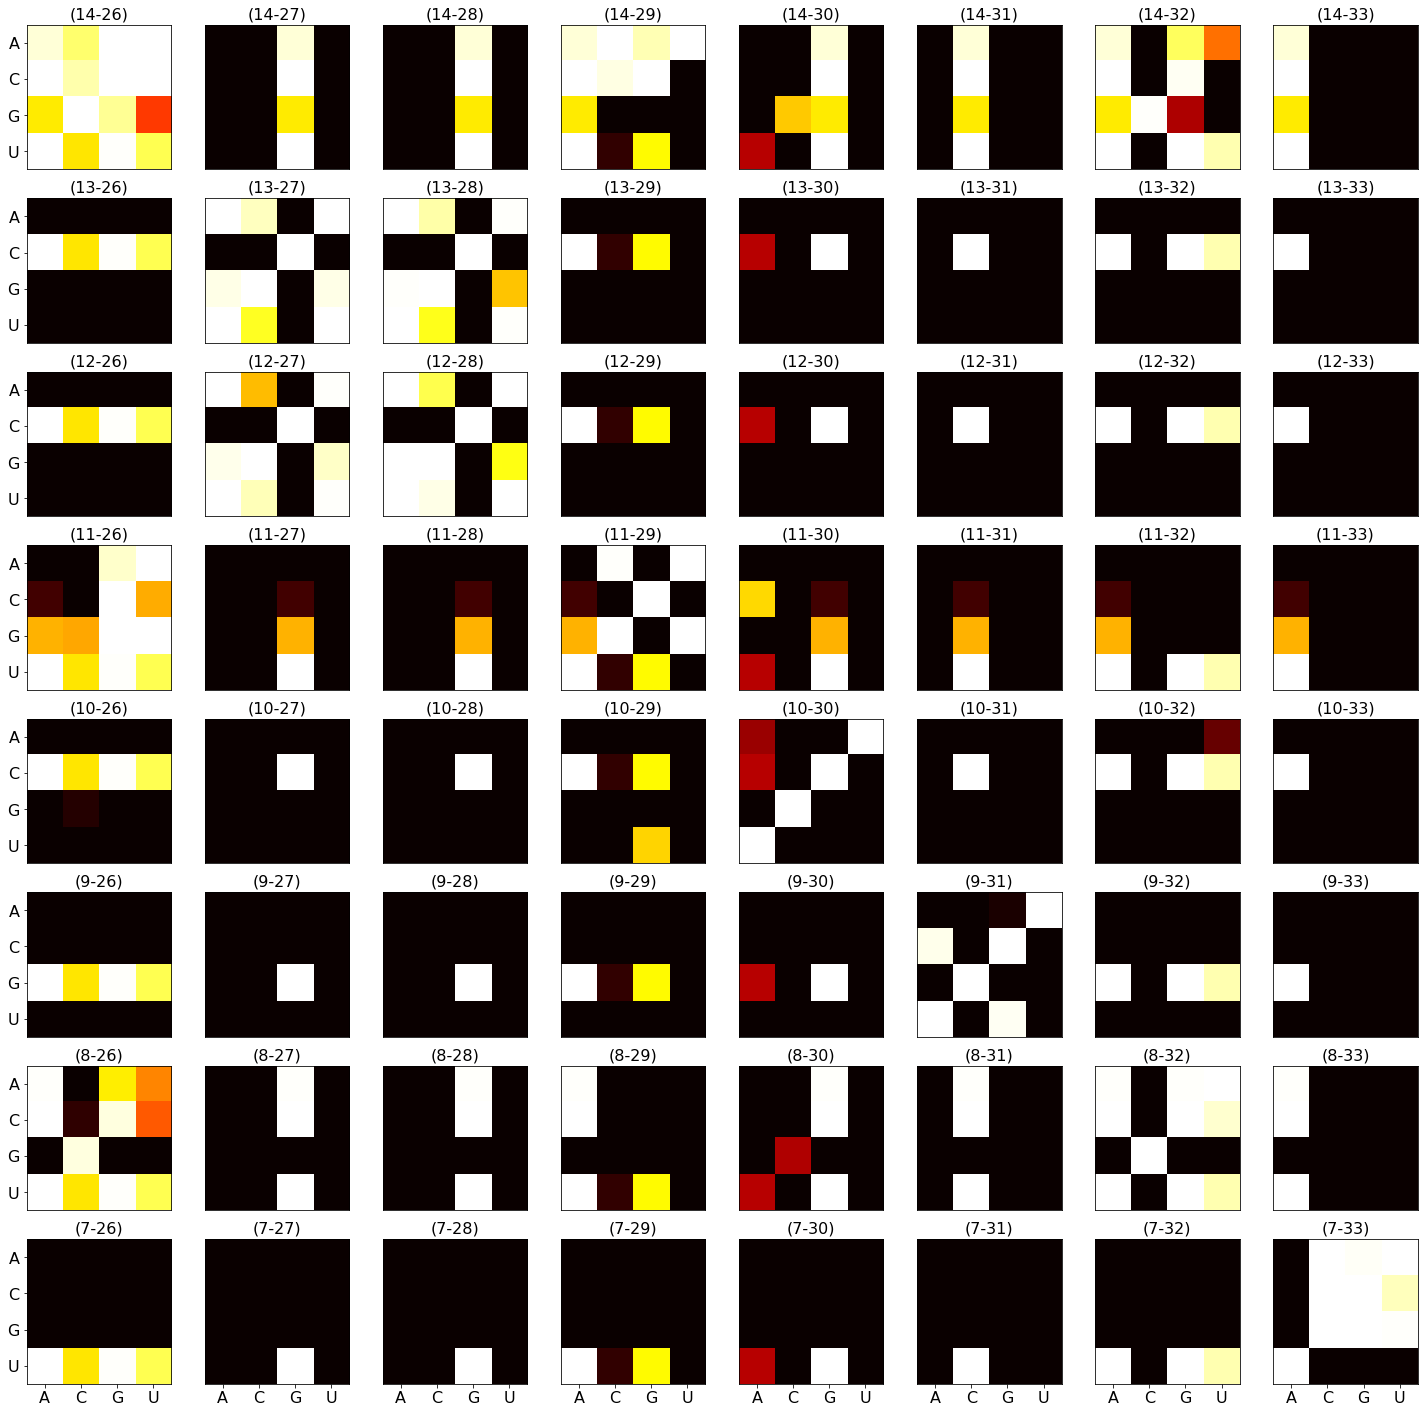

In [201]:
mut = mutagenesis_2[3]
fig = plt.figure(figsize=(25,25))
k = 1
stem1 = range(7,15)[::-1]
stem2 = range(26,34)
for i in stem1:
    for j in stem2:
        plt.subplot(len(stem1),len(stem2),k)
        plt.imshow(mut[i,j,:,:], interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
        
        if k in range(1,len(stem1)**2, len(stem1)):
            plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
        else:
            plt.yticks([])
        if k in range(len(stem1)**2-len(stem1)+1,len(stem1)**2+1):
            plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
        else:
            plt.xticks([])

        plt.title('('+str(i)+'-'+str(j)+')', fontsize=16)
        k += 1

outfile = os.path.join(save_path, 'mutagenesis_stem_positions.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


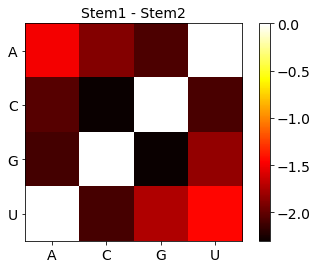

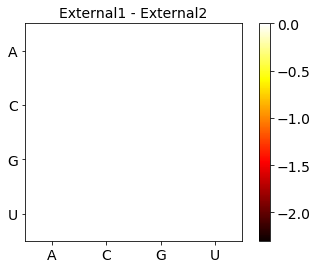

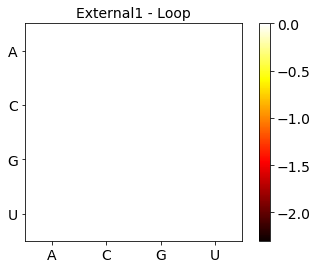

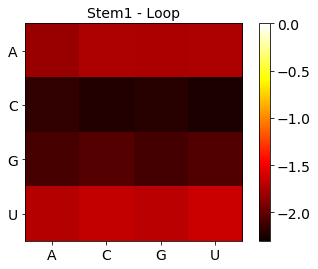

In [114]:
fontsize = 14
pairs = np.vstack([range(7,16), range(25,34)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(8,14), range(17,23)[::-1]]).T

fig = plt.figure()
plt.imshow(np.mean(mut[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Stem2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_stem1-stem2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - External2', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1-external2.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('External1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
outfile = os.path.join(save_path, 'mutagenesis_external1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.mean(mut[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='hot', vmin=-2.3, vmax=0.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize) 
plt.title('Stem1 - Loop', fontsize=fontsize)
plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize)
plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=fontsize);
outfile = os.path.join(save_path, 'mutagenesis_stem1_loop.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [19]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset = np.vstack([range(6,17), range(25,36)[::-1]]).T

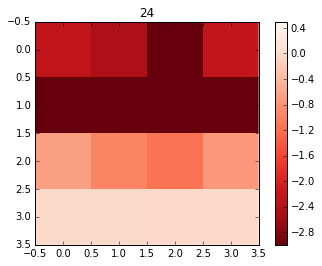

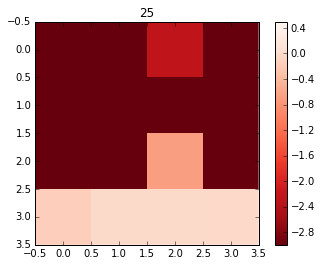

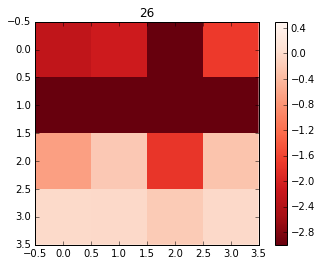

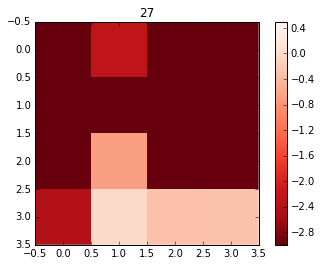

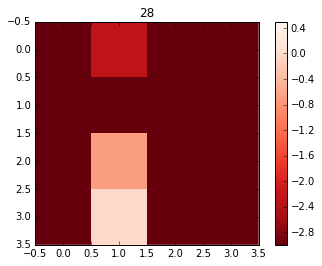

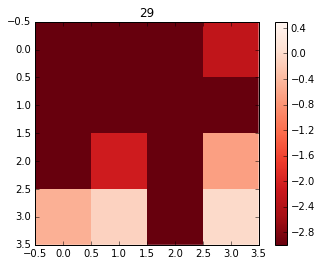

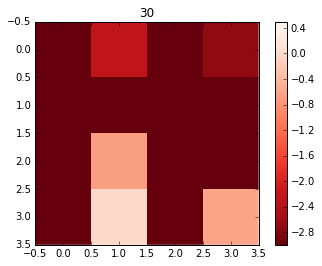

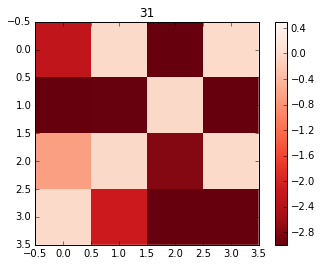

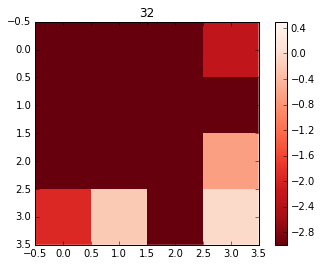

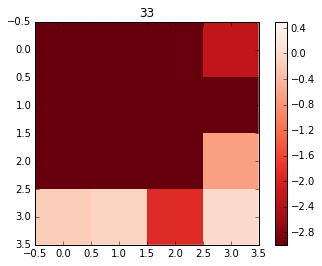

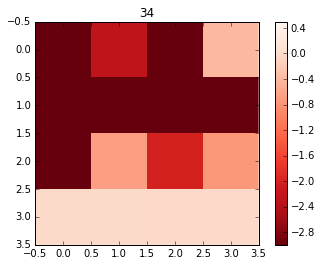

In [24]:
base = 9
for i in range(24,35):
    plt.figure()
    plt.imshow(mut[base,i,:,:], interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
    plt.colorbar()
    plt.title(str(i))

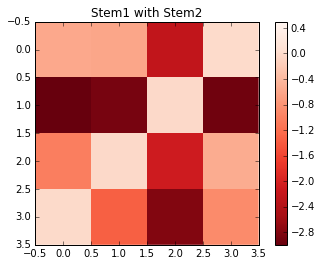

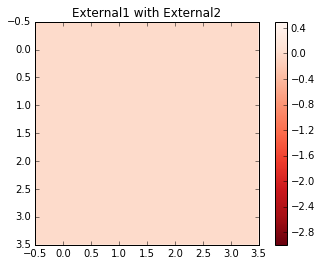

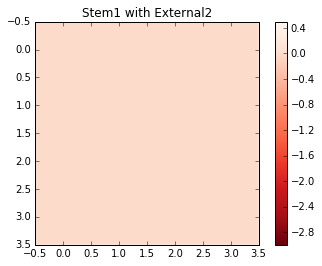

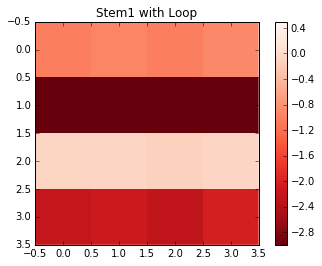

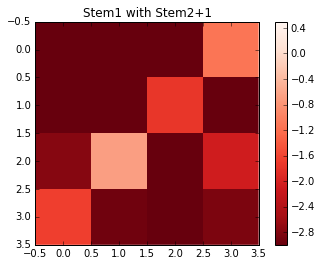

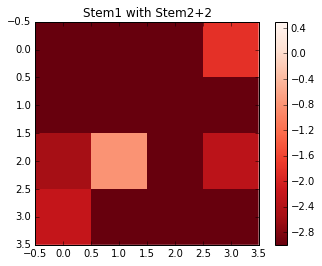

In [20]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset1 = np.vstack([range(6,17), range(25,36)[::-1]]).T
pairs_offset2 = np.vstack([range(6,17), range(26,37)[::-1]]).T

plt.figure()
plt.imshow(np.mean(mut[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('Stem1 with Stem2')

plt.figure()
plt.imshow(np.mean(mut[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('External1 with External2')

plt.figure()
plt.imshow(np.mean(mut[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('Stem1 with External2')

plt.figure()
plt.imshow(np.mean(mut[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('Stem1 with Loop')

plt.figure()
plt.imshow(np.mean(mut[pairs_offset1[:,0],pairs_offset1[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('Stem1 with Stem2+1')

plt.figure()
plt.imshow(np.mean(mut[pairs_offset2[:,0],pairs_offset2[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.5)
plt.colorbar()
plt.title('Stem1 with Stem2+2')



In [15]:
norm = np.sum(np.sum(mut**2, axis=3), axis=2)
plt.imshow(norm, interpolation='none')
plt.colorbar()

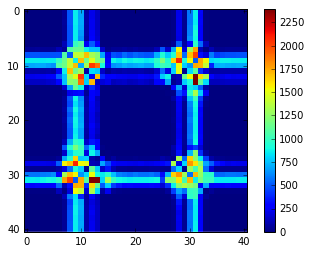

In [18]:
plt.imshow(norm, interpolation='none')
plt.colorbar()

In [73]:

def mutual_information(X, batch_size=1024):

    eps = 1e-7 # small number to prevent indefinite/infinite values
    N, seq_length, num_alphabet = X.shape    
    M = np.zeros((seq_length, seq_length))

    bg = BatchGenerator(N, batch_size, shuffle=False)

    # loop over first position
    for i in range(seq_length):

        # loop over second position
        for j in range(i):

            # calculate number of co-occurences of AA
            
            f_ij = 0
            for index in bg.indices:
                f_ij += np.dot(np.transpose(X[index,i,:]), X[index,j,:])/N

            # count occurence of individual AA
            f_i = np.mean(f_ij, axis=0, keepdims=True)
            f_j = np.mean(f_ij, axis=1, keepdims=True)

            # calculate mutual information 
            M[i,j] = np.sum(f_ij*np.log(f_ij/(f_i*f_j + eps) + eps))

    # fill out upper symmetric triangle 
    M += M.T

    return M  


class BatchGenerator():
    """ helper class to generate mini-batches """

    def __init__(self, num_data, batch_size=128, shuffle=False):

        self.num_data = num_data
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(num_data/batch_size))
        self.batch_index = 0
        self.generate_batches(batch_size, shuffle)

    def generate_batches(self, batch_size=128, shuffle=False):

        if shuffle == True:
            index = np.random.permutation(self.num_data)
        else:
            index = range(self.num_data)

        self.indices = []
        for i in range(self.num_batches):
            self.indices.append(index[i*self.batch_size:i*self.batch_size+self.batch_size])

        # get remainder
        index = range(self.num_batches*self.batch_size, self.num_data)
        if index:
            self.indices.append(index)

        # reset batch_index
        self.batch_index = 0

    def next_batch(self, data):
        """Generate next mini-batch of data"""
        indices = np.sort(self.indices[self.batch_index])

        if isinstance(data, (list, tuple)):
            data_batch = []
            for vals in data:
                data_batch.append(vals[indices])
        else:
            data_batch = data[indices]

        self.batch_index += 1
        if self.batch_index == self.num_batches:
            self.batch_index = 0

        return data_batch

    def get_batch_index(self):
        return self.batch_index

    def get_num_batches(self):
        return self.num_batches




In [42]:
pos_index = np.where(test['targets'][:,0] == 1)[0]

index = pos_index[1]
X = np.expand_dims(test['inputs'][index], axis=0)
    
_, seq_length, _, num_alphabet = X.shape

# get wild-type score
wt_score = nntrainer.get_activations(sess, {'inputs': X}, layer='output')

# generate mutagenesis sequences
num_mut = seq_length**2*num_alphabet**2
X_mut = np.reshape(np.dot(np.ones((num_mut, 1)), X), [num_mut, seq_length, 1, num_alphabet])
k = 0
for i in range(seq_length):
    for j in range(seq_length):
        for m in range(num_alphabet):
            for n in range(num_alphabet):
                X_mut[k, i, 0, :] = 0
                X_mut[k, i, 0, m] = 1        
                X_mut[k, j, 0, :] = 0
                X_mut[k, j, 0, n] = 1        
                k += 1

# get second order mutagenesis score
mut_scores = nntrainer.get_activations(sess, {'inputs': X_mut}, layer='output')


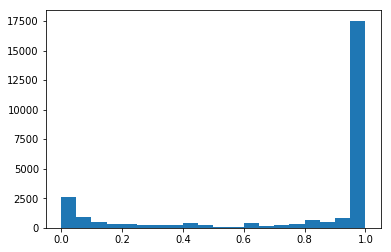

In [43]:
plt.hist(mut_scores, bins=20);

In [44]:
mut_index = np.where(mut_scores > 0.95)[0]

X2 = np.squeeze(X_mut[mut_index])


M = mutual_information(X2)

In [47]:
M

array([[0.        , 2.77288823, 2.77288823, ..., 2.77288823, 2.77288823,
        2.77288823],
       [2.77288823, 0.        , 2.77288823, ..., 2.77288823, 2.77288823,
        2.77288823],
       [2.77288823, 2.77288823, 0.        , ..., 2.77288823, 2.77288823,
        2.77288823],
       ...,
       [2.77288823, 2.77288823, 2.77288823, ..., 0.        , 2.77288823,
        2.77288823],
       [2.77288823, 2.77288823, 2.77288823, ..., 2.77288823, 0.        ,
        2.77288823],
       [2.77288823, 2.77288823, 2.77288823, ..., 2.77288823, 2.77288823,
        0.        ]])

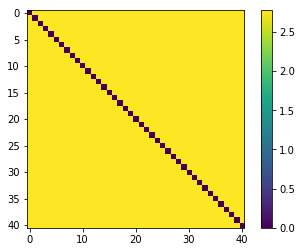

In [48]:
plt.imshow(M)
plt.colorbar()

In [9]:
from six.moves import cPickle

with open(os.path.join(save_path, 'mutagenesis_pos.pickle'), 'wb') as f:
    cPickle.dump(mutagenesis_1, f)
    cPickle.dump(mutagenesis_2, f)

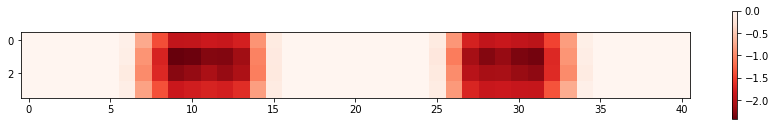

In [10]:
plt.figure(figsize=(15,2))
plt.imshow(np.mean(mutagenesis_1, axis=0).T, interpolation=None, cmap='Reds_r')
plt.colorbar()

In [11]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset = np.vstack([range(6,17), range(25,36)[::-1]]).T

Text(0.5,1,u'Stem1 with Stem2+2')

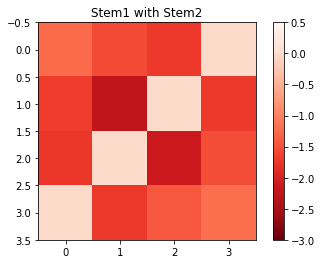

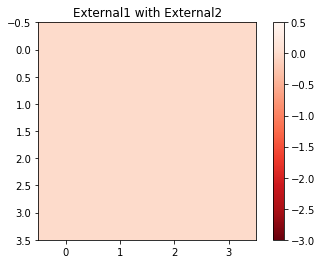

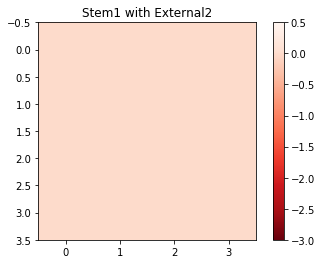

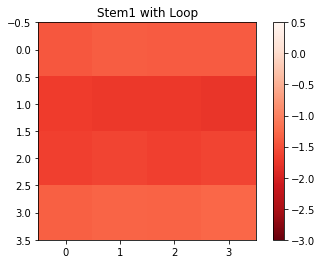

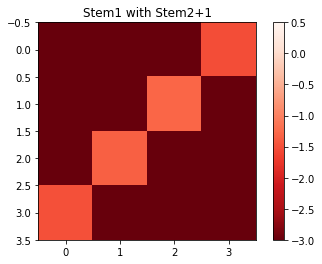

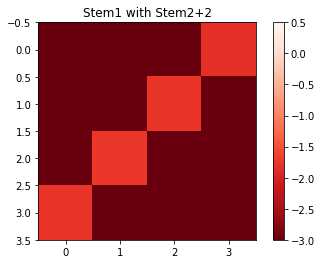

In [17]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset1 = np.vstack([range(6,17), range(25,36)[::-1]]).T
pairs_offset2 = np.vstack([range(6,17), range(26,37)[::-1]]).T

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('Stem1 with Stem2')

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('External1 with External2')

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('Stem1 with External2')

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('Stem1 with Loop')

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[pairs_offset1[:,0],pairs_offset1[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('Stem1 with Stem2+1')

plt.figure()
plt.imshow(np.mean(np.mean(mutagenesis_2, axis=0)[pairs_offset2[:,0],pairs_offset2[:,1]], axis=0), interpolation='none', cmap='Reds_r', vmin=-3, vmax=0.0)
plt.colorbar()
plt.title('Stem1 with Stem2+2')



# example 

In [108]:
pos_index = np.where(train['targets'][:,0] == 1)[0]


index = pos_index[13]
train['targets'][index]

array([1.], dtype=float32)

In [109]:
np.argmax(np.squeeze(X), axis=1)

array([0, 2, 1, 1, 2, 2, 3, 0, 0, 0, 0, 2, 0, 3, 1, 3, 2, 1, 0, 0, 2, 1,
       3, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 3, 2, 0, 3, 3, 1, 3, 1])

In [110]:
# get wild-type score`
X = np.expand_dims(train['inputs'][index], axis=0)
first_mutagenesis = first_order_mutagenesis(sess, nntrainer, X)

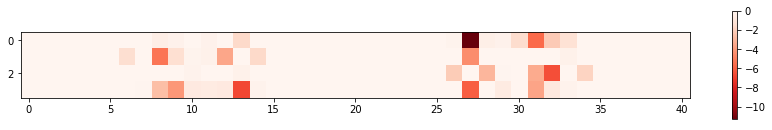

In [111]:
plt.figure(figsize=(15,2))
plt.imshow(first_mutagenesis.T, interpolation=None, cmap='Reds_r')
plt.colorbar()

In [112]:
second_mutagenesis = second_order_mutagenesis(sess, nntrainer, X)

In [113]:
pairs = np.vstack([range(6,17), range(24,35)[::-1]]).T
externals = np.vstack([range(0,6), range(35,41)[::-1]]).T
external_loop = np.vstack([range(0,6), range(17,23)[::-1]]).T
pair_loop = np.vstack([range(10,16), range(17,23)[::-1]]).T
pairs_offset = np.vstack([range(6,17), range(25,36)[::-1]]).T

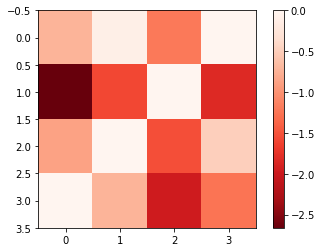

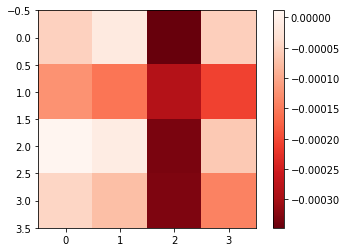

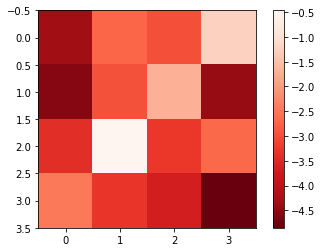

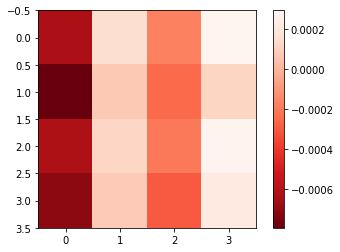

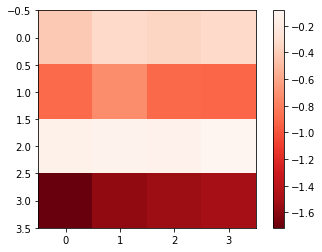

In [114]:
plt.figure()
plt.imshow(np.mean(second_mutagenesis[pairs[:,0],pairs[:,1]], axis=0), interpolation='none', cmap='Reds_r')
plt.colorbar()

plt.figure()
plt.imshow(np.mean(second_mutagenesis[externals[:,0],externals[:,1]], axis=0), interpolation='none', cmap='Reds_r')
plt.colorbar()

plt.figure()
plt.imshow(np.mean(second_mutagenesis[pairs_offset[:,0],pairs_offset[:,1]], axis=0), interpolation='none', cmap='Reds_r')
plt.colorbar()

plt.figure()
plt.imshow(np.mean(second_mutagenesis[external_loop[:,0],external_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r')
plt.colorbar()

plt.figure()
plt.imshow(np.mean(second_mutagenesis[pair_loop[:,0],pair_loop[:,1]], axis=0), interpolation='none', cmap='Reds_r')
plt.colorbar()

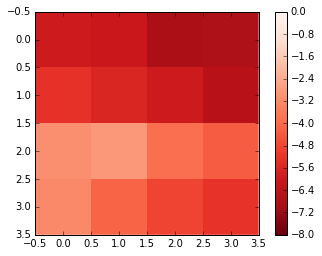

In [249]:
plt.imshow(np.mean(second_mutagenesis[pairs[:,0],pairs[:,1]-6], axis=0), interpolation='none', cmap='Reds_r', vmin=-8, vmax=0)
plt.colorbar()

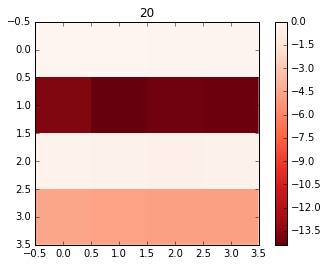

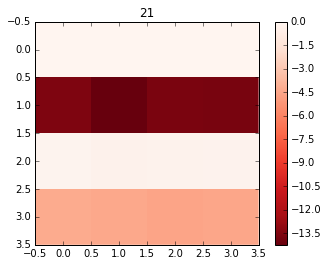

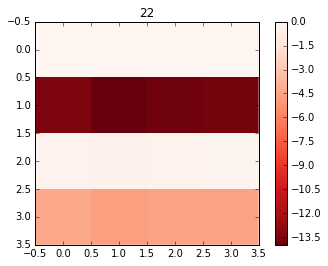

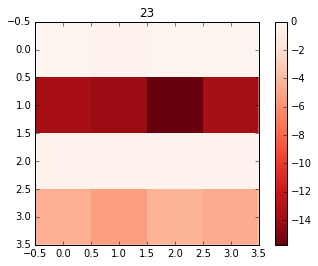

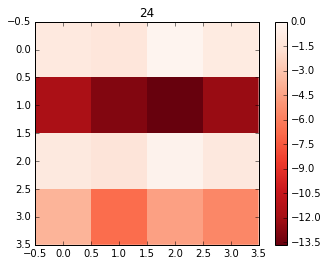

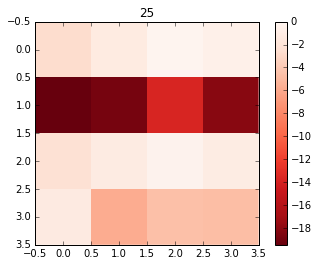

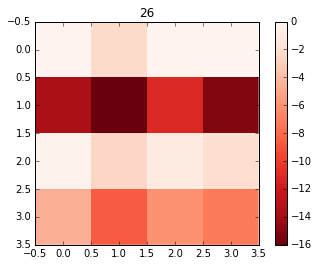

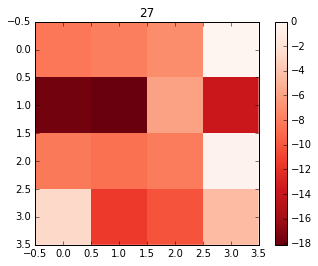

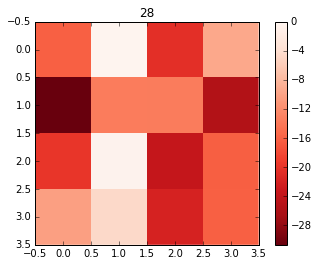

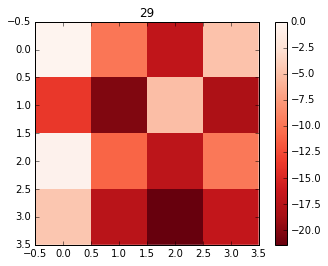

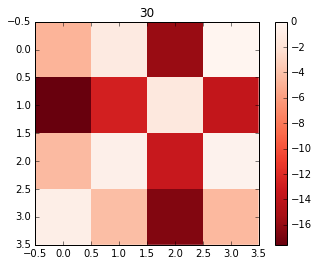

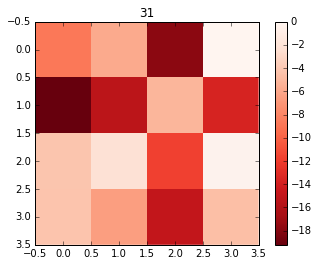

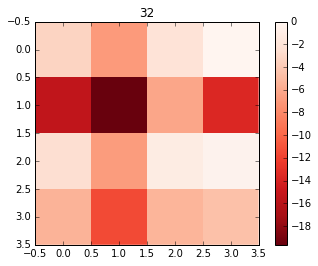

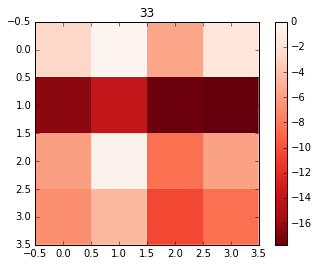

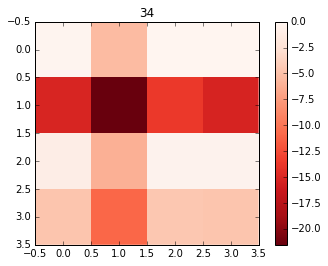

In [140]:

for i in range(20,35):

    plt.figure()
    plt.imshow(second_mutagenesis[10,i], interpolation='none', vmax=0, cmap='Reds_r')
    plt.colorbar()
    plt.title(i)

In [102]:
struct = '. . . . . . ( ( ( ( (  (  (  (  (  (  (  .  .  .  .  .  .  .  )  )  )  )  )  )  )  )  )  )  )  .  .  ....'
          0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
# 0 - 5 external
# 6-16 paired (10)
# 17-23 loop
# 24-34 paired (9)
# 35-40 external

pairs =
6 - 34
7 - 33
8 - 32
9 - 31
10 - 30
11 - 29
12 - 28
13 - 27
14 - 26
15 - 25 
16 - 24


In [ ]:
APC = np.mean(M, axis=0, keepdims=True)*np.mean(M, axis=1, keepdims=True)/np.mean(M)
M_correct = M-APC

for i in range(M_correct.shape[0]):
    M_correct[i,i]= 0


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(M, interpolation='none')
plt.colorbar()
try:
    plt.scatter(Y[:,0], Y[:,1], s=100, marker='o', facecolors='none', edgecolors='r')
except:
    m=0
plt.subplot(1,2,2)
plt.imshow(M_correct, interpolation='none')
plt.colorbar()
try:
    plt.scatter(Y[:,0], Y[:,1], s=100, marker='o', facecolors='none', edgecolors='r')
except:
    m=0

In [ ]:
neg_index = np.where(test['targets'][:,0] == 0)[0]

mutagenesis_1_neg = np.zeros((len(pos_index), seq_length, num_alphabet))
mutagenesis_2_neg = np.zeros((len(pos_index), seq_length, seq_length, num_alphabet, num_alphabet))
for i, index in enumerate(neg_index):
    X = np.expand_dims(test['inputs'][index], axis=0)
    mutagenesis_1_neg[i,:,:] = first_order_mutagenesis(sess, nntrainer, X)
    mutagenesis_2_neg[i,:,:,:,:] = second_order_mutagenesis(sess, nntrainer, X)
    
    if np.mod(i+1, 200) == 0:
        print("%d out of %d"%(i+1,len(neg_index)))

In [ ]:
with open(os.path.join(save_path, 'mutagenesis_neg.pickle'), 'wb') as f:
    cPickle.dump(mutagenesis_1_neg, f)
    cPickle.dump(mutagenesis_2_neg, f)